<a href="https://colab.research.google.com/github/sheeers/cap-comp215/blob/main/Research_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shirs and Cole Project 2

In [ ]:
%matplotlib inline

import time
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [ ]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [ ]:
import numpy as np
import matplotlib

class DiseaseSpread:
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    VACCINATED = 3
    INFECTED2 = 4

    cmap = [(0.8, 0.8, 0.8), (1, 0, 0), (0, 0, 1), (0, 1, 0),(1, 0.5, 0)]  # gray, red, blue, green, brown
    disease_colour_map = matplotlib.colors.ListedColormap(cmap)

    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])

    def __init__(self, n, infection_rate=0.1, recovery_rate=0.01, initial_infected_rate=0.01,
                 initial_vaccinated_rate=0.1,
                 neighbor_vaccine_boost=0.05, infection_rate2=0.2, recovery_rate2=0.02):
        self.n = n
        self.step_count = 0
        self.infection_rate = infection_rate
        self.infection_rate2 = infection_rate2
        self.recovery_rate = recovery_rate
        self.recovery_rate2 = recovery_rate2
        self.neighbor_vaccine_boost = neighbor_vaccine_boost
        self.vaccine_effectiveness = 0.9 #Vaccination effecteviness - currently set to 90%
        self.state = np.random.choice([self.SUSCEPTIBLE, self.INFECTED, self.VACCINATED], (n, n),
                                      p=[1-initial_infected_rate-initial_vaccinated_rate,
                                         initial_infected_rate,
                                         initial_vaccinated_rate,])

    def step(self):
        new_state = self.state.copy()
        infected = (self.state == self.INFECTED)
        infected2 = (self.state == self.INFECTED2)
        susceptible = (self.state == self.SUSCEPTIBLE)
        vaccinated = (self.state == self.VACCINATED)

#Introduce second strain at step 50
        if self.step_count == 50:
            self.introduce_second_strain()

        # Rule 1: Infection Spread
        infection_risk = correlate2d(infected, self.kernel, mode='same', boundary='wrap') > 0
        infections = np.random.rand(self.n, self.n) < self.infection_rate
        new_state[susceptible & infection_risk & infections] = self.INFECTED

        # Rule 1b: Infection Spread for Second Strain (ignores vaccination)
        infection_risk2 = correlate2d(infected2, self.kernel, mode='same', boundary='wrap') > 0
        infections2 = np.random.rand(self.n, self.n) < self.infection_rate2
        new_state[(self.state == self.SUSCEPTIBLE) & infection_risk2 & infections2] = self.INFECTED2

        # Reduced infection risk for vaccinated individuals
        vaccine_infections = np.random.rand(self.n, self.n) < (self.infection_rate * (1 - self.vaccine_effectiveness))
        new_state[vaccinated & infection_risk & vaccine_infections] = self.INFECTED



        # Higher chance of vaccination if neighbours infected
        infected_neighbors = correlate2d(infected, self.kernel, mode='same', boundary='wrap') > 0
        enhanced_vaccine_chance = np.random.rand(self.n, self.n) < self.neighbor_vaccine_boost
        new_state[susceptible & infected_neighbors & enhanced_vaccine_chance] = self.VACCINATED

        # Rule 2: Recovery
        recovery_chance = np.random.rand(self.n, self.n) < self.recovery_rate
        recovery_chance2 = np.random.rand(self.n, self.n) < self.recovery_rate2
        new_state[infected & recovery_chance] = self.RECOVERED

        self.state = new_state
        self.step_count += 1

    def introduce_second_strain(self):
        susceptible = (self.state == self.SUSCEPTIBLE)
        new_second_strain = (np.random.rand(self.n, self.n) < 0.05) & susceptible
        self.state[new_second_strain] = self.INFECTED2

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()
        total_cells = self.state.size
        pct_infected = np.sum(self.state == self.INFECTED) / total_cells
        pct_vaccinated = np.sum(self.state == self.VACCINATED) / total_cells


        title = f'Time: {step} - Infected: {pct_infected:.2%}, Vaccinated: {pct_vaccinated:.2%}'
        axes.imshow(self.state, cmap=self.disease_colour_map, vmin=0, vmax=len(self.cmap)-1)
        axes.set_title(title)
        axes.axis('off')




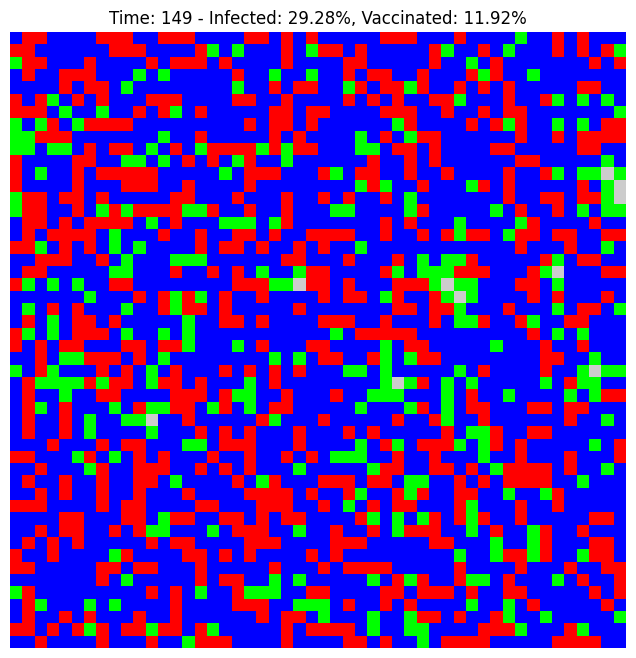

In [ ]:

disease = DiseaseSpread(n=50, infection_rate=0.1, recovery_rate=0.01, initial_infected_rate=0.05, initial_vaccinated_rate=0.01, infection_rate2=0.2, recovery_rate2=0.02)

anim = Animation2D(disease, frames=150)

anim.animate(interval=0.01)


Had some problems implementing a second strain. It was meant to implement after 50 steps and ignore vaccination + recovered.